# *WE will be using U-NET ARCHITECTURE for our image segmentation task*

installing necessary libraries

In [1]:
pip install opencv-python

In [2]:
pip install albumentations

In [3]:
!pip install keras-applications

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 875.7 kB/s eta 0:00:00


## Here we will be carrying out our 1st step, i.e., **Dataset Preparation**

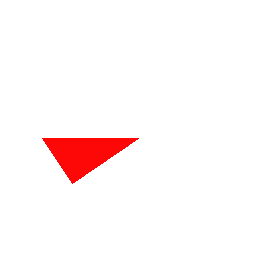

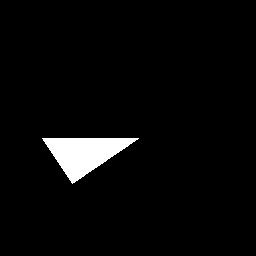

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

# Creating a function to generate synthetic RGB images with simple shapes, along with their masks
def generate_image_with_mask(size=(256, 256), num_shapes=1):
    # Background is white (255) in RGB
    image = np.ones((size[0], size[1], 3), dtype=np.uint8) * 255
    # Initialize mask, background is black
    mask = np.zeros((size[0], size[1]), dtype=np.uint8)

    for _ in range(num_shapes):
        # randomly choose between circle, square or triangle, using np.random module
        shape = np.random.choice(['circle', 'square', 'triangle'])

        if shape == 'circle':
            # select the coordinates of the center randomly
            center = np.random.randint(50, size[0] - 50, 2)
            # select the radius of the circle randomly
            radius = np.random.randint(20, 80)
            # generate a random color for the circle
            color = tuple(np.random.randint(0, 256, 3).tolist())
            # Draw filled circle
            cv2.circle(image, tuple(center), radius, color, -1)
            # Draw filled circle on the mask
            cv2.circle(mask, tuple(center), radius, 255, -1)

        elif shape == 'square':
            # select the top-left corner's coordinates of the square randomly
            top_left = np.random.randint(20, size[0] - 70, 2)
            # select the side of the square randomly
            square_side = np.random.randint(30, 100)
            # calculate the bottom right corner's coordinates
            bottom_right = top_left + square_side
            # generate a random color for the square
            color = tuple(np.random.randint(0, 256, 3).tolist())
            # Draw filled square
            cv2.rectangle(image, tuple(top_left), tuple(bottom_right), color, -1)
            # Draw filled rectangle on the mask
            cv2.rectangle(mask, tuple(top_left), tuple(bottom_right), 255, -1)

        elif shape == 'triangle':
            # select the 3 points' coordinates of the triangle randomly
            pt1 = np.random.randint(20, size[0] - 70, 2)
            pt2 = pt1 + [np.random.randint(30, 100), 0]
            pt3 = pt1 + [np.random.randint(20, 60), np.random.randint(30, 90)]
            points = np.array([pt1, pt2, pt3], np.int32)
            # generate a random color for the triangle
            color = tuple(np.random.randint(0, 256, 3).tolist())
            # Draw filled triangle
            cv2.fillPoly(image, [points], color)
            # Draw filled triangle on the mask
            cv2.fillPoly(mask, [points], 255)

    return image, mask

# Example usage:
image, mask = generate_image_with_mask()

# Show the generated image and mask
cv2_imshow(image)
cv2_imshow(mask)
cv2.waitKey(0)
cv2.destroyAllWindows()

## mounting drive to store our images and their corresponding masks

In [5]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## defining our directory path where we want to save our images and masks

In [6]:
import os
# Define the directory where you want to save the images in your Google Drive
img_dir = "/content/drive/My Drive/img_dataset"
mask_dir = "/content/drive/My Drive/mask_dataset"

### setting seed for same kind of output on any device

In [7]:
import tensorflow as tf
import numpy as np

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for NumPy
np.random.seed(42)

### Here we are creating and storing our images and masks at their assigned loactions at the google drive

In [8]:
# Create the image directory if it doesn't exist
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

# Create the mask directory if it doesn't exist
if not os.path.exists(mask_dir):
    os.makedirs(mask_dir)

img_filenames = []
mask_filenames = []

# Create a function to save synthetic images and their corresponding masks
def save_images_with_masks(num_images=2000):
    for i in range(num_images):
        # Generate the synthetic image and mask
        image, mask = generate_image_with_mask()

        # Define the filenames for the image and mask
        img_filename = os.path.join(img_dir, f"image_{i}.png")
        img_filenames.append(img_filename)
        mask_filename = os.path.join(mask_dir, f"mask_{i}.png")
        mask_filenames.append(mask_filename)

        # Save the image and mask
        cv2.imwrite(img_filename, image)
        cv2.imwrite(mask_filename, mask)

# Define the function to generate synthetic images with corresponding masks
save_images_with_masks()

# This is our heart of the process, our U-NET architecture

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l1
from tensorflow.keras.applications import MobileNetV2

# Define Mish activation function
def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

def unet(input_shape, num_classes):
    # Define input layer
    inputs = Input(input_shape)

    # Load MobileNetV2 base model
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    # Set the MobileNet layers as non-trainable
    base_model.trainable = False

    # Get layers from MobileNet
    encoder_layers = base_model(inputs)
    encoder_layers = UpSampling2D(size=(32, 32))(encoder_layers)
    encoder_layers = Conv2D(3, 3, padding='same', kernel_regularizer=l1(0.001))(encoder_layers)
    encoder_layers = Activation(mish)(encoder_layers)

    # Contracting Path
    conv1 = Conv2D(64, 3, padding='same', kernel_regularizer=l1(0.001))(encoder_layers)
    conv1 = Activation(mish)(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, padding='same', kernel_regularizer=l1(0.001))(conv1)
    conv1 = Activation(mish)(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, padding='same', kernel_regularizer=l1(0.001))(pool1)
    conv2 = Activation(mish)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, padding='same', kernel_regularizer=l1(0.001))(conv2)
    conv2 = Activation(mish)(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, padding='same', kernel_regularizer=l1(0.001))(pool2)
    conv3 = Activation(mish)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Dropout(0.5)(conv3)  # Add dropout with a dropout rate of 0.5
    conv3 = Conv2D(256, 3, padding='same', kernel_regularizer=l1(0.001))(conv3)
    conv3 = Activation(mish)(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, padding='same', kernel_regularizer=l1(0.001))(pool3)
    conv4 = Activation(mish)(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Dropout(0.5)(conv4)  # Add dropout with a dropout rate of 0.5
    conv4 = Conv2D(512, 3, padding='same', kernel_regularizer=l1(0.001))(conv4)
    conv4 = Activation(mish)(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, padding='same', kernel_regularizer=l1(0.001))(pool4)
    conv5 = Activation(mish)(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Dropout(0.5)(conv5)  # Add dropout with a dropout rate of 0.5
    conv5 = Conv2D(1024, 3, padding='same', kernel_regularizer=l1(0.001))(conv5)
    conv5 = Activation(mish)(conv5)
    conv5 = BatchNormalization()(conv5)

    # Expansive Path
    up6 = Concatenate()([UpSampling2D(size=(2, 2))(conv5), conv4])
    conv6 = Conv2D(512, 3, padding='same', kernel_regularizer=l1(0.001))(up6)
    conv6 = Activation(mish)(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(0.5)(conv6)  # Add dropout with a dropout rate of 0.5
    conv6 = Conv2D(512, 3, padding='same', kernel_regularizer=l1(0.001))(conv6)
    conv6 = Activation(mish)(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Concatenate()([UpSampling2D(size=(2, 2))(conv6), conv3])
    conv7 = Conv2D(256, 3, padding='same', kernel_regularizer=l1(0.001))(up7)
    conv7 = Activation(mish)(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Dropout(0.5)(conv7)  # Add dropout with a dropout rate of 0.5
    conv7 = Conv2D(256, 3, padding='same', kernel_regularizer=l1(0.001))(conv7)
    conv7 = Activation(mish)(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Concatenate()([UpSampling2D(size=(2, 2))(conv7), conv2])
    conv8 = Conv2D(128, 3, padding='same', kernel_regularizer=l1(0.001))(up8)
    conv8 = Activation(mish)(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, padding='same', kernel_regularizer=l1(0.001))(conv8)
    conv8 = Activation(mish)(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Concatenate()([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(64, 3, padding='same', kernel_regularizer=l1(0.001))(up9)
    conv9 = Activation(mish)(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, padding='same', kernel_regularizer=l1(0.001))(conv9)
    conv9 = Activation(mish)(conv9)
    conv9 = BatchNormalization()(conv9)

    outputs = Conv2D(num_classes, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

# Define Binary Cross-Entropy (BCE) Loss
bce_loss = BinaryCrossentropy()

# Use BCE Loss instead of Dice Loss
def bce_loss_wrapper(y_true, y_pred):
    return bce_loss(y_true, y_pred)

# Define input shape and number of classes
input_shape = (256, 256, 3)
num_classes = 1

# Create U-Net model
model = unet(input_shape, num_classes)

# Compile the model with Dice loss
model.compile(optimizer='adam', loss=bce_loss_wrapper, metrics=['accuracy'])

# Summary of the model
model.summary()


9406464/9406464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)           2257984   ['input_1[0][0]']             
 tional)                                                                                          
                                                                                                  
 up_sampling2d (UpSampling2  (None, 256, 256, 1280)       0         ['mobilenetv2_1.00_224[0][0]']
 D)                                                                                               
                               

### This code is used to create a class for **preprocessing** and preparing our data for **training** and **validating**

In [10]:
import albumentations as A

class CustomDataset(tf.keras.utils.Sequence):
    def __init__(self, img_dir, mask_dir, img_filenames, mask_filenames, batch_size, image_size, shuffle):
        self.batch_size = batch_size
        self.image_size = image_size
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.shuffle = shuffle
        self.img_filenames = img_filenames
        self.mask_filenames = mask_filenames
        self.indexes = np.arange(len(self.img_filenames))

        # Define the augmentation transformations
        self.transform = A.Compose([
            # Randomly crop and resize the images
            A.RandomResizedCrop(256, 256),
            # Randomly flip the images horizontally
            A.HorizontalFlip(p=0.5),
            # Randomly flip the images vertically
            A.VerticalFlip(p=0.5),
            # Adjust brightness, contrast, saturation, and hue
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.5),
            # Randomly rotate the images
            A.Rotate(limit=20, p=0.5),
            # Normalize image
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.img_filenames) // self.batch_size

    def __getitem__(self, index):
      index = int(index)  # Convert index to integer explicitly

      # Get the indices for the current batch
      start_idx = index * self.batch_size
      end_idx = (index + 1) * self.batch_size

      # Get the actual indices for the current batch
      batch_indices = self.indexes[start_idx:end_idx]

      images = []
      masks = []

      for idx in batch_indices:  # Use batch_indices instead of indexes
        img_name = self.img_filenames[idx]
        mask_name = self.mask_filenames[idx]

        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        # Read images and masks
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Resize images and masks
        image = cv2.resize(image, self.image_size)
        mask = cv2.resize(mask, self.image_size)

        # Apply data augmentation
        augmented = self.transform(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']

        images.append(image)
        masks.append(mask)

      return np.array(images), np.array(masks)

## The below code creates training and validating sets and fits them into our model to calculate usefull metrices like **loss** and **accuracy**

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau

X_train, X_val, y_train, y_val = train_test_split(img_filenames, mask_filenames, test_size=0.2, random_state=42)

training_dataset = CustomDataset(img_dir, mask_dir, X_train, y_train, batch_size=8, image_size=(256, 256), shuffle=False)
validation_dataset = CustomDataset(img_dir, mask_dir, X_val, y_val, batch_size=8, image_size=(256, 256), shuffle=False)

# Train your model
num_epochs = 10
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
history = model.fit(training_dataset, epochs=num_epochs, validation_data=validation_dataset, callbacks=[reduce_lr])

# Evaluate your model
loss, accuracy = model.evaluate(validation_dataset)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

Epoch 1/10
 10/200 [>.............................] - ETA: 5:17:13 - loss: 39.0985 - accuracy: 0.6441